# Mushroom Classification - Common Genus's Images
By Rokas Burneika for Deep Learning Sprint 1

***

## About Dataset

**Content**

There is 9 folders of images of most common Northern European mushrooms genuses inside of this dataset. Each folder consist of from 300 to 1500 selected images of mushrooms genuses. Labels are the folder's names.


**Acknowledgements**

Special thanks to mycologist's society of Northern Europe, who provided the sources of most common mushrooms in this area and checked data and labels.

To download dataset uncomment the code below:

In [1]:
# ! kaggle datasets download -d maysee/mushrooms-classification-common-genuss-images -p data --unzip

## Goal

Goal is to create a model with a pretrained weights that could classify mushrooms.

***

# Module and Data Import

**Modules**

In [2]:
import datetime
import glob
import lightning as L
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import ImageFile
import seaborn as sns
from skimage import io
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import time
import torch
import torch.functional as F
import torch.nn as nn
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from tqdm.notebook import tqdm 
from utils import *


ImageFile.LOAD_TRUNCATED_IMAGES = True
np.random.seed(42)

classes = [
    'Boletus', 
    'Entoloma', 
    'Russula', 
    'Suillus', 
    'Lactarius', 
    'Amanita', 
    'Agaricus', 
    'Hygrocybe', 
    'Cortinarius'
]

**Data**

In [3]:
df = pd.DataFrame([(path, label) for label in classes for path in glob.glob(f'./data/Mushrooms/{label}/*')], columns=['path', 'label'])
df['label_cat'] = df['label'].apply(lambda x: classes.index(x))
df.head()

path    label  label_cat
0  ./data/Mushrooms/Boletus/1022_Z4KX3bZR6LY.jpg  Boletus          0
1  ./data/Mushrooms/Boletus/0834_XZ_Q0TFA-h0.jpg  Boletus          0
2  ./data/Mushrooms/Boletus/0140_l02XUqkuX24.jpg  Boletus          0
3  ./data/Mushrooms/Boletus/0647_VuGFN8uliNA.jpg  Boletus          0
4  ./data/Mushrooms/Boletus/0276_eulHrmGFYAQ.jpg  Boletus          0

After importing data, I labeled them according to their index in `classes`.

In [4]:
for i in range(len(df)):
    df.loc[i, ['height', 'width', 'layers']] = get_shape(df.loc[i, 'path'])

Also extracting width and height of images for EDA part.

***

# Data Cleaning

After looking through the images, I have found some images that do not contain mushrooms or nothing at all. 

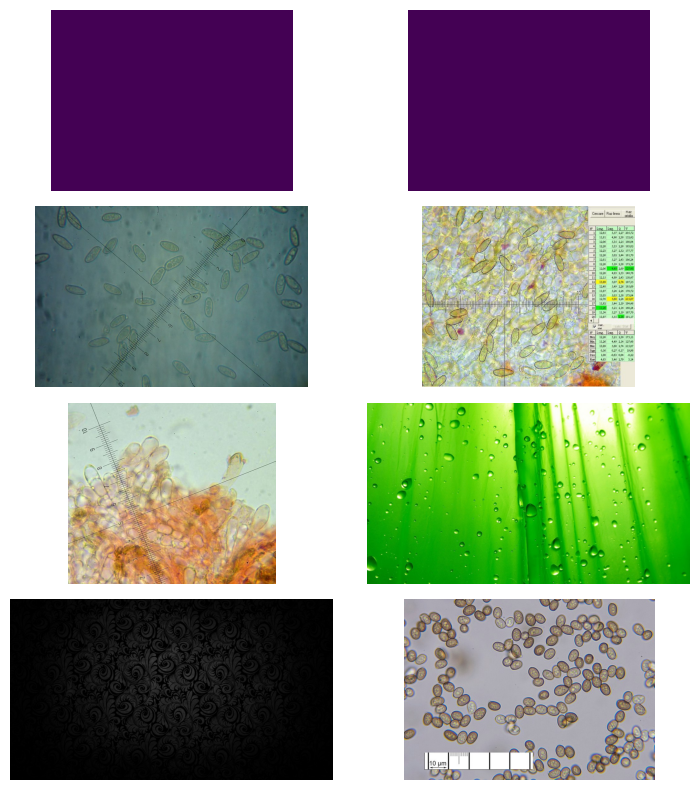

In [5]:
outliers = [
    './data/Mushrooms/Boletus/0105_7lVm0lLO6FQ.jpg',
    './data/Mushrooms/Boletus/0051_rBIC-Uy9KzI.jpg',
    './data/Mushrooms/Agaricus/273_ZwxysL6gjVQ.jpg',
    './data/Mushrooms/Boletus/0572_zdESww0j-to.jpg',
    './data/Mushrooms/Boletus/0573_O4Ftoobc-mM.jpg',
    './data/Mushrooms/Boletus/0726_wNJGG_syL80.jpg',
    './data/Mushrooms/Lactarius/0375_E_5sHNAa0DU.jpg',
    './data/Mushrooms/Russula/151_yX7oI-mM9hk.jpg'
]

outliers = df[df['path'].isin(outliers)]
show_images(outliers, columns=2)

There are two images, both from Boletus class that have only 1 layer. This could cause problems for our model. They are both showed as purple rectangles.

Images 3, 4, 5, and 8 (from left to right from top to bottom) are still considered mushrooms, but since other images are fully grown mushrooms it is good to remove them.

Images 6 and 7 look like screen background images.

In [6]:
df = df.drop(outliers.index)

Dropping these outliers.

***

# EDA

## Class Distribution

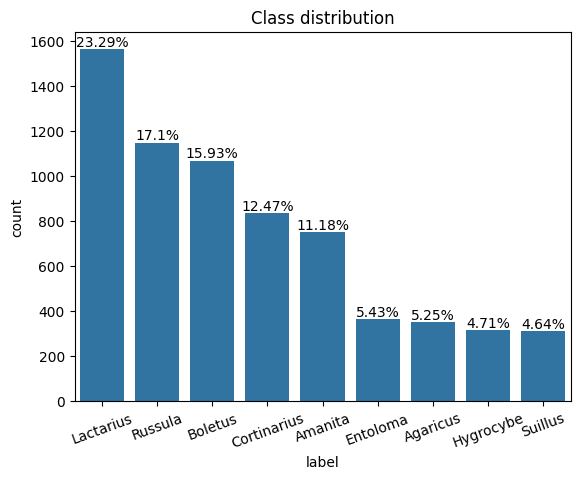

In [7]:
labels = (df['label'].value_counts(normalize=True).round(4) * 100).astype(str) + '%'

ax = sns.barplot(df['label'].value_counts())
ax.bar_label(ax.containers[0],
             labels=labels,
             label_type='edge')

plt.title('Class distribution')
plt.xticks(rotation=20)
plt.show()

We can see the biggest class `Lactarius` takes up of around a quarter of all instances.

Classes `Entoloma`, `Agaricus`, `Hygrocybe` and `Suillus` are around 5% each of all images.

## Image Sizes by Class

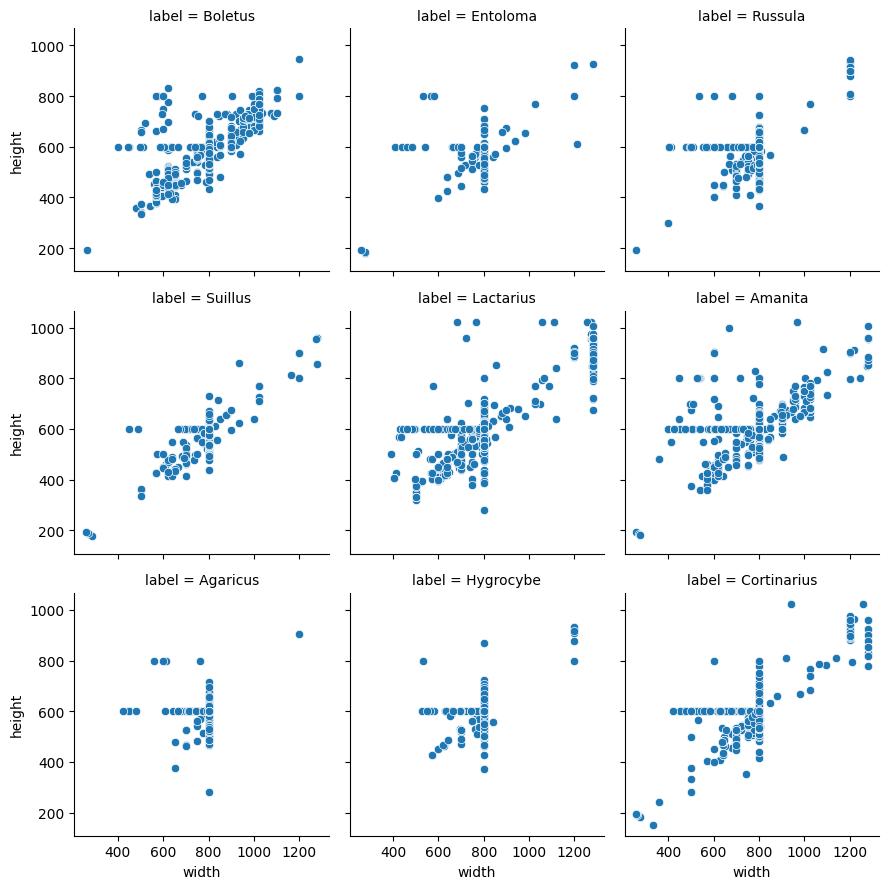

In [8]:
sns.relplot(df, 
            x='width', 
            y='height',
            col='label',
            kind='scatter',
            col_wrap=3,
            height=3)
            
plt.show()

Smallest images are around 200x200 pixels, while biggest are over 1200x1000 pixels.

There are trends of height of 600 pixels, width of 800 pixels.

## Class Samples

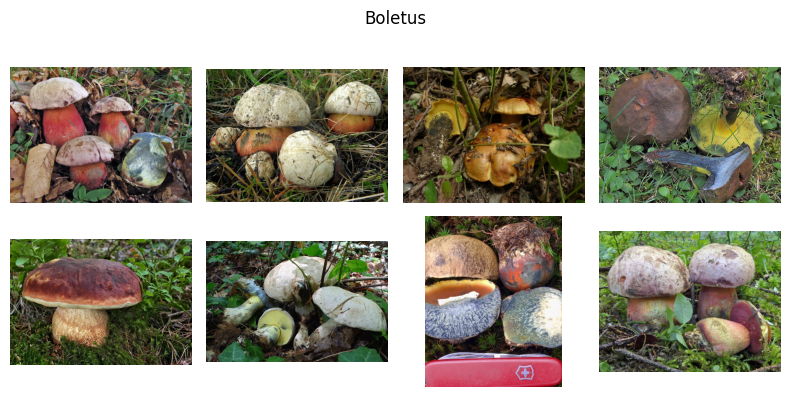

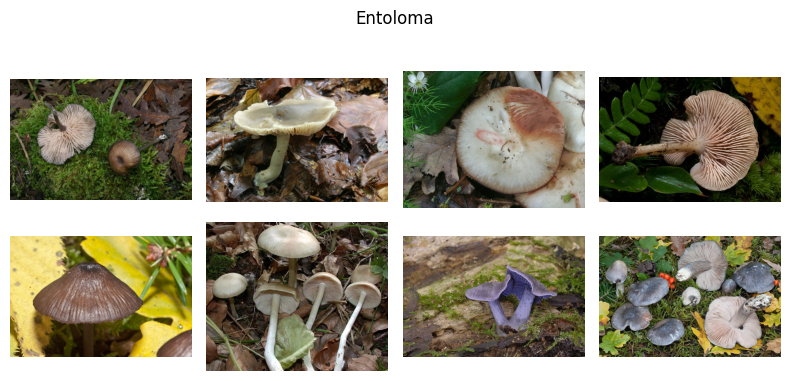

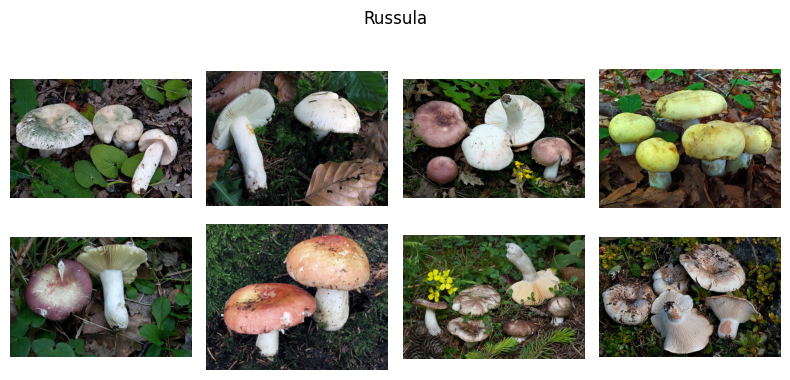

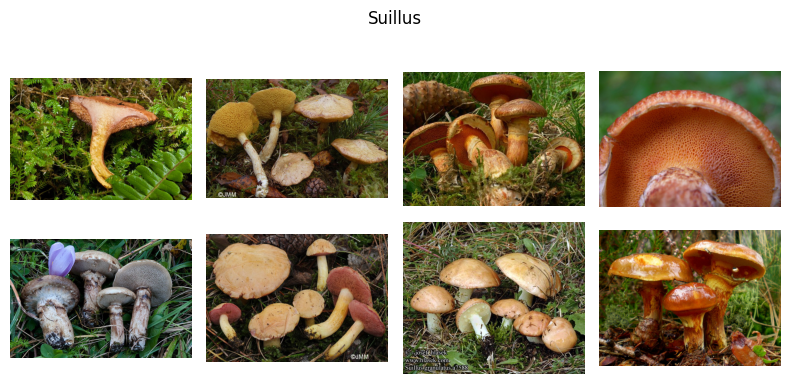

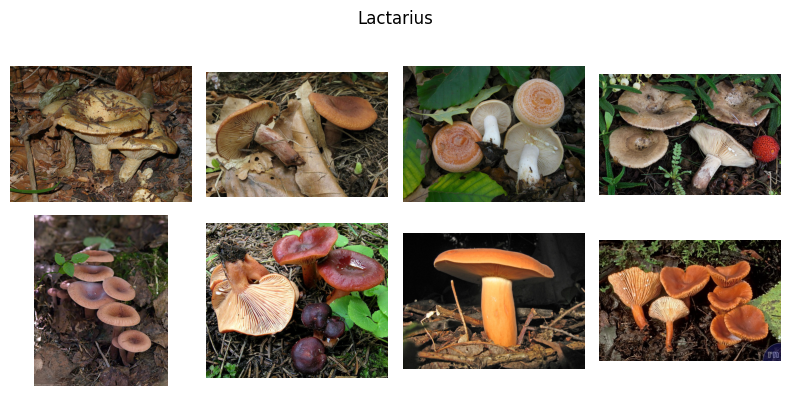

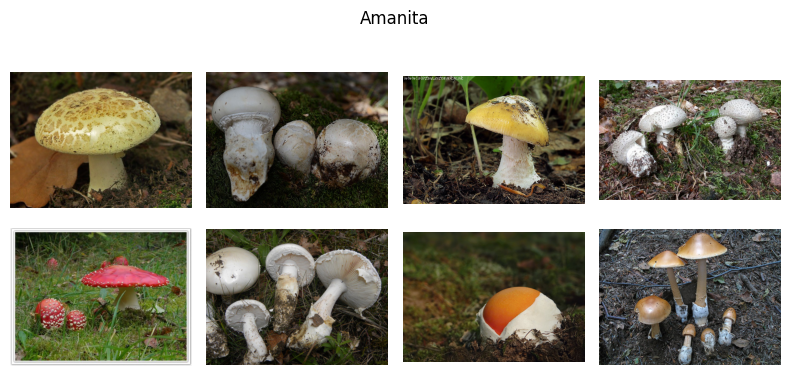

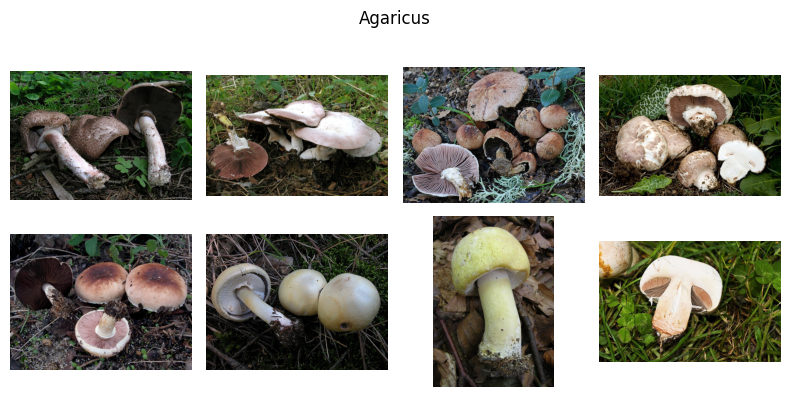

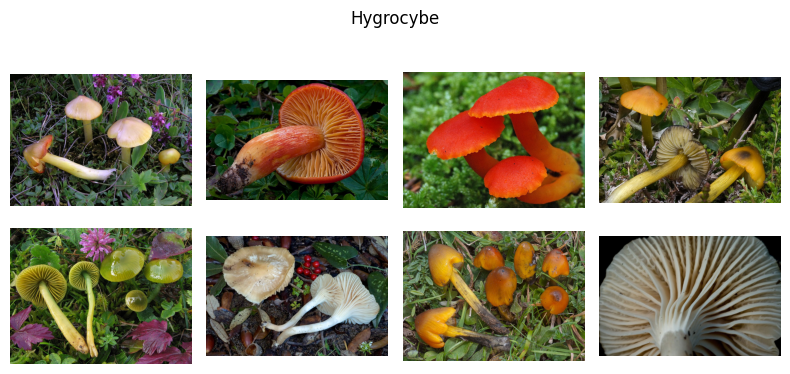

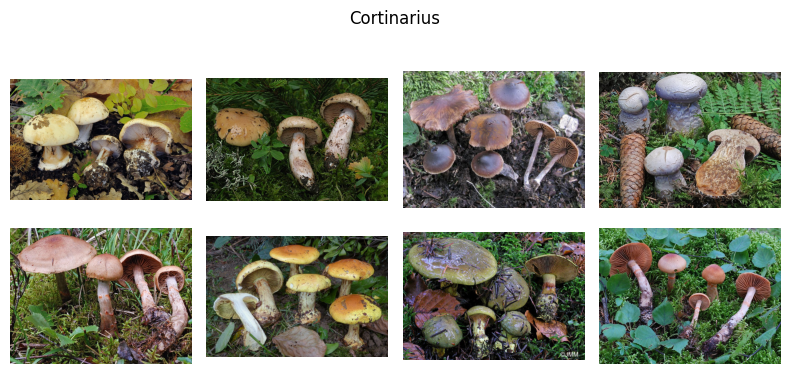

In [9]:
show_class_samples(df, classes)

We can `Boletus` are mushrooms are brownish and yellowish, a bit similar to those one would image after hearing word "mushroom" but fatter.

`Entoloma` mushrooms look like one I would not pick.

`Russula` has bland colored heads of blueish, redish, yellowish colors and a white body.

`Suillus` mushrooms are very orange and look quite small.

`Lactarius` are similar to `Suillus`, the main difference is that their cap is turned inside out.

I would not eat `Amanita` in a hundred years. White body with sometimes red or redish cap with white spots on it.

`Agaricus` are white mushrooms, food enjoyers would call them champignons.

`Hygrocybe` are mushrooms straight out of fantasy world. Long stems, whide caps and vibrant colors.

`Cortinarius` really are a mushroom anyone would imagine. Brownish in colour, long but not too thin stems with darker caps.

***

# Modeling

This is the modeling part.

We have to do some preparation.

## Train, Val, Test split

In [10]:
train, val = train_test_split(df, test_size=0.3, shuffle=True)
val, test = train_test_split(val, test_size=0.5, shuffle=True)

Checking if distributions match.

In [11]:
train['label'].value_counts(normalize=True)

label
Lactarius      0.229016
Russula        0.167874
Boletus        0.159139
Cortinarius    0.124414
Amanita        0.112058
Agaricus       0.056242
Entoloma       0.055390
Hygrocybe      0.050064
Suillus        0.045803
Name: proportion, dtype: float64

In [12]:
val['label'].value_counts(normalize=True)

label
Lactarius      0.237575
Russula        0.187873
Boletus        0.145129
Cortinarius    0.130219
Amanita        0.115308
Suillus        0.051690
Entoloma       0.047714
Agaricus       0.045726
Hygrocybe      0.038767
Name: proportion, dtype: float64

## Transformer

Since we are using `io.imread` which return a numpy array, we need to transform it to PIL image.

Then we can resize it and crop it.

After that, transformer turn it into tensor and normalizes the values based on ImageNet values.

In [13]:
transformer = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

## Dataset Class

Creating a class for our Dataset.

In [14]:
class MushroomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.transform = transform
        self.paths = data.iloc[:, 0].values
        self.labels = data.iloc[:, 2].values

    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        image = io.imread(self.paths[index])

        if self.transform:
            image = self.transform(image)

        return image, self.labels[index]

## Creating DataLoaders

Creating Datasets and DataLoaders.

I am using batch size of 30 and utilizing all available threads.

In [15]:
train_dataset = MushroomDataset(train, transformer)
val_dataset = MushroomDataset(val, transformer)
test_dataset = MushroomDataset(test, transformer)

dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset),
    'test': len(test_dataset)
}

batch_size = 30

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=12)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=12)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=12)

## Creating Train Function

In [16]:
def train_model(model, fabric, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    losses = pd.DataFrame(columns=['train', 'val', 'train_acc', 'val_acc'])

    for epoch in tqdm(range(num_epochs), desc='Epochs: '):

        for phase in ['train', 'val']:

            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_acc = 0

            for inputs, labels in tqdm(dataloaders[phase], desc=f'{phase}: ', leave=False):
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, predictions = torch.max(outputs, dim=1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        fabric.backward(loss)
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_acc += torch.sum(predictions == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_acc.double() / dataset_sizes[phase]

            losses.loc[epoch, phase] = epoch_loss
            losses.loc[epoch, f'{phase}_acc'] = f'{epoch_acc}'

    return losses

There is a lot to unpack here.

For each epoch this function runs two phases: `train` and `val` (short for validation).

For each phase it calculates running loss and accuracy.

If the phase is `train`, model is ten to training mode, else in evaluating mode. Difference between them is that `.train()` keeps some layers active and `.eval()` does not.

Function only calculates gradients in training mode.

Weight optimization is done in batches.

After the phase is complete the function calculates it's total loss and accuracy and saves them in a DataFrame.

Function return a DataFrame with both `train` and `val` losses and accuracies for each epoch.

## First Model

In [17]:
torch.set_float32_matmul_precision('medium')

fabric = L.Fabric()
fabric.launch()

model = torchvision.models.resnet152(weights='IMAGENET1K_V1')

for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features

model.fc = nn.Linear(num_ftrs, len(classes))

optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

model, optimizer = fabric.setup(model, optimizer)

train_dataloader, val_dataloader, test_dataloader = fabric.setup_dataloaders(train_dataloader, val_dataloader, test_dataloader)

temp_df = train['label_cat'].value_counts()
weights = temp_df.sum() / (temp_df * len(temp_df))
weights = torch.tensor(weights.sort_index().values, dtype=torch.float32)
weights = weights.to(device='cuda')

criterion = nn.CrossEntropyLoss(weight=weights)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.3)

dataloaders = {
    'train': train_dataloader,
    'val': val_dataloader,
    'test': test_dataloader
}

First model is utilizing `Fabric` class from Pytorch-Lightning module, which automatically sets up models and DataLoaders to be used on GPU.

Model is pretrained ResNet152 with last layer changed to a Linear layer.

For Optimizer I am using SGD.

Also, since our data is imbalanced, I create a list of class weights to pass onto loss calculator which is CrossEntropyLoss.

Here I am using StepLR for Learning Rate Scheduler.

### Training First Model

In [18]:
losses = train_model(model, fabric, dataloaders, criterion, optimizer, scheduler, num_epochs=50)

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

train:   0%|          | 0/157 [00:00<?, ?it/s]

val:   0%|          | 0/34 [00:00<?, ?it/s]

train:   0%|          | 0/157 [00:00<?, ?it/s]

val:   0%|          | 0/34 [00:00<?, ?it/s]

train:   0%|          | 0/157 [00:00<?, ?it/s]

val:   0%|          | 0/34 [00:00<?, ?it/s]

train:   0%|          | 0/157 [00:00<?, ?it/s]

val:   0%|          | 0/34 [00:00<?, ?it/s]

train:   0%|          | 0/157 [00:00<?, ?it/s]

val:   0%|          | 0/34 [00:00<?, ?it/s]

train:   0%|          | 0/157 [00:00<?, ?it/s]

val:   0%|          | 0/34 [00:00<?, ?it/s]

train:   0%|          | 0/157 [00:00<?, ?it/s]

val:   0%|          | 0/34 [00:00<?, ?it/s]

train:   0%|          | 0/157 [00:00<?, ?it/s]

val:   0%|          | 0/34 [00:00<?, ?it/s]

train:   0%|          | 0/157 [00:00<?, ?it/s]

val:   0%|          | 0/34 [00:00<?, ?it/s]

train:   0%|          | 0/157 [00:00<?, ?it/s]

val:   0%|          | 0/34 [00:00<?, ?it/s]

train:   0%|          | 0/157 [00:00<?, ?it/s]

val:   0%|          | 0/34 [00:00<?, ?it/s]

train:   0%|          | 0/157 [00:00<?, ?it/s]

val:   0%|          | 0/34 [00:00<?, ?it/s]

train:   0%|          | 0/157 [00:00<?, ?it/s]

val:   0%|          | 0/34 [00:00<?, ?it/s]

train:   0%|          | 0/157 [00:00<?, ?it/s]

val:   0%|          | 0/34 [00:00<?, ?it/s]

train:   0%|          | 0/157 [00:00<?, ?it/s]

val:   0%|          | 0/34 [00:00<?, ?it/s]

train:   0%|          | 0/157 [00:00<?, ?it/s]

val:   0%|          | 0/34 [00:00<?, ?it/s]

train:   0%|          | 0/157 [00:00<?, ?it/s]

val:   0%|          | 0/34 [00:00<?, ?it/s]

train:   0%|          | 0/157 [00:00<?, ?it/s]

val:   0%|          | 0/34 [00:00<?, ?it/s]

train:   0%|          | 0/157 [00:00<?, ?it/s]

val:   0%|          | 0/34 [00:00<?, ?it/s]

train:   0%|          | 0/157 [00:00<?, ?it/s]

val:   0%|          | 0/34 [00:00<?, ?it/s]

train:   0%|          | 0/157 [00:00<?, ?it/s]

val:   0%|          | 0/34 [00:00<?, ?it/s]

train:   0%|          | 0/157 [00:00<?, ?it/s]

val:   0%|          | 0/34 [00:00<?, ?it/s]

train:   0%|          | 0/157 [00:00<?, ?it/s]

val:   0%|          | 0/34 [00:00<?, ?it/s]

train:   0%|          | 0/157 [00:00<?, ?it/s]

val:   0%|          | 0/34 [00:00<?, ?it/s]

train:   0%|          | 0/157 [00:00<?, ?it/s]

val:   0%|          | 0/34 [00:00<?, ?it/s]

train:   0%|          | 0/157 [00:00<?, ?it/s]

val:   0%|          | 0/34 [00:00<?, ?it/s]

train:   0%|          | 0/157 [00:00<?, ?it/s]

val:   0%|          | 0/34 [00:00<?, ?it/s]

train:   0%|          | 0/157 [00:00<?, ?it/s]

val:   0%|          | 0/34 [00:00<?, ?it/s]

train:   0%|          | 0/157 [00:00<?, ?it/s]

val:   0%|          | 0/34 [00:00<?, ?it/s]

train:   0%|          | 0/157 [00:00<?, ?it/s]

val:   0%|          | 0/34 [00:00<?, ?it/s]

train:   0%|          | 0/157 [00:00<?, ?it/s]

val:   0%|          | 0/34 [00:00<?, ?it/s]

train:   0%|          | 0/157 [00:00<?, ?it/s]

val:   0%|          | 0/34 [00:00<?, ?it/s]

train:   0%|          | 0/157 [00:00<?, ?it/s]

val:   0%|          | 0/34 [00:00<?, ?it/s]

train:   0%|          | 0/157 [00:00<?, ?it/s]

val:   0%|          | 0/34 [00:00<?, ?it/s]

train:   0%|          | 0/157 [00:00<?, ?it/s]

val:   0%|          | 0/34 [00:00<?, ?it/s]

train:   0%|          | 0/157 [00:00<?, ?it/s]

val:   0%|          | 0/34 [00:00<?, ?it/s]

train:   0%|          | 0/157 [00:00<?, ?it/s]

val:   0%|          | 0/34 [00:00<?, ?it/s]

train:   0%|          | 0/157 [00:00<?, ?it/s]

val:   0%|          | 0/34 [00:00<?, ?it/s]

train:   0%|          | 0/157 [00:00<?, ?it/s]

val:   0%|          | 0/34 [00:00<?, ?it/s]

train:   0%|          | 0/157 [00:00<?, ?it/s]

val:   0%|          | 0/34 [00:00<?, ?it/s]

train:   0%|          | 0/157 [00:00<?, ?it/s]

val:   0%|          | 0/34 [00:00<?, ?it/s]

train:   0%|          | 0/157 [00:00<?, ?it/s]

val:   0%|          | 0/34 [00:00<?, ?it/s]

train:   0%|          | 0/157 [00:00<?, ?it/s]

val:   0%|          | 0/34 [00:00<?, ?it/s]

train:   0%|          | 0/157 [00:00<?, ?it/s]

val:   0%|          | 0/34 [00:00<?, ?it/s]

train:   0%|          | 0/157 [00:00<?, ?it/s]

val:   0%|          | 0/34 [00:00<?, ?it/s]

train:   0%|          | 0/157 [00:00<?, ?it/s]

val:   0%|          | 0/34 [00:00<?, ?it/s]

train:   0%|          | 0/157 [00:00<?, ?it/s]

val:   0%|          | 0/34 [00:00<?, ?it/s]

train:   0%|          | 0/157 [00:00<?, ?it/s]

val:   0%|          | 0/34 [00:00<?, ?it/s]

train:   0%|          | 0/157 [00:00<?, ?it/s]

val:   0%|          | 0/34 [00:00<?, ?it/s]

train:   0%|          | 0/157 [00:00<?, ?it/s]

val:   0%|          | 0/34 [00:00<?, ?it/s]

### Plotting Model Losses

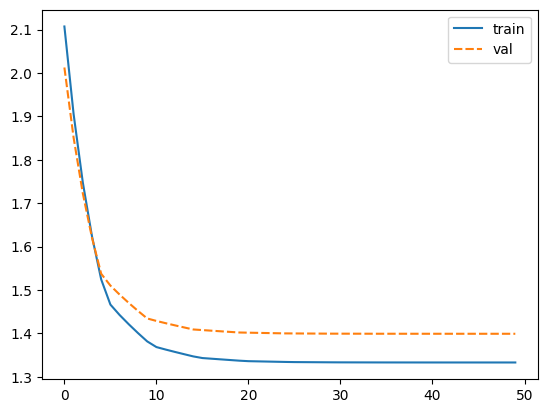

In [19]:
sns.lineplot(losses[['train', 'val']])
plt.show()

We can see that the loss for `train` dataset is lower than `val` but not by much.

Both curves are in similar shape flattening out at around 20th epoch.

### Plotting Model Accuracy 

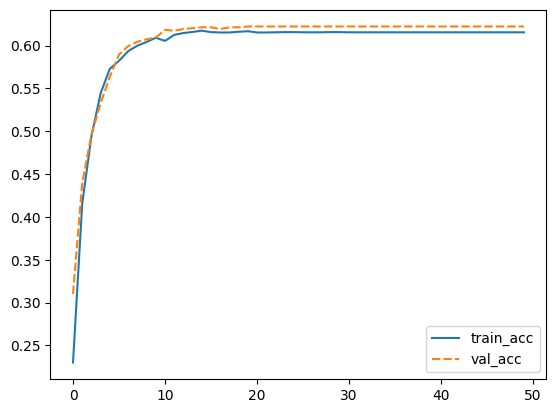

In [20]:
sns.lineplot(losses[['train_acc', 'val_acc']].astype(float))
plt.show()

For `val` accuracy reaches 50% at around 5h epoch and reaches it's peak at around 18-19th epoch.

Meaning we could expect a 50% accuracy on `test` dataset.

### Testing

Test accuracy: 0.6322067379951477


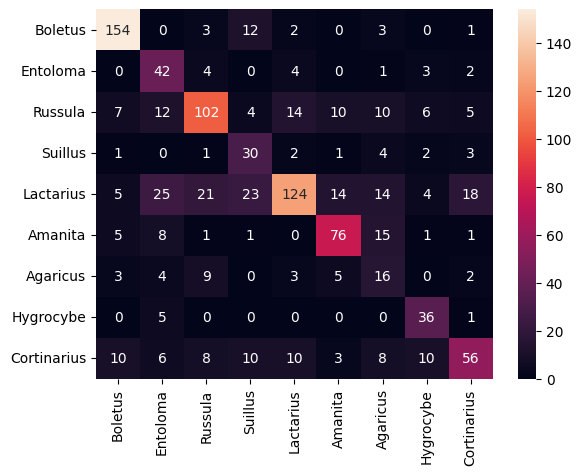

In [21]:
total_correct = 0

all_labels = []
all_predictions = []

for inputs, labels in test_dataloader:
    outputs = model(inputs)
    _, predictions = torch.max(outputs, dim=1)
    total_correct += torch.sum(predictions == labels)

    for label, pred in zip(labels, predictions):
        label = int(label.data.cpu().numpy())
        pred = int(pred.data.cpu().numpy())
        
        all_labels.append(label)
        all_predictions.append(pred)

accuracy = total_correct / dataset_sizes['test']

print(f'Test accuracy: {accuracy}')

conf = confusion_matrix(all_labels, all_predictions)
sns.heatmap(conf, xticklabels=classes, yticklabels=classes, annot=True, fmt='g')
plt.show()

Test accuracy of first model is 63.22%

## Second Model

In [22]:
class ImagenetTransferModel(L.LightningModule):
    def __init__(self):
        super().__init__()

        backbone = torchvision.models.resnet152(weights='IMAGENET1K_V1')

        for param in backbone.parameters():
            param.requires_grad = False

        num_filters = backbone.fc.in_features
        layers = list(backbone.children())[:-1]
        self.feature_extractor = nn.Sequential(*layers)

        num_target_classes = len(classes)
        self.classifier = nn.Sequential(
            nn.Linear(num_filters, 256),
            nn.ReLU(),
            nn.Linear(256, num_target_classes)
        )

        self.criterion = nn.CrossEntropyLoss(weight=weights)

    def forward(self, x):
        self.feature_extractor.eval()
        with torch.no_grad():
            representations = self.feature_extractor(x).flatten(1)
        x = self.classifier(representations)
        return x

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=0.001)
        scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, total_steps=self.trainer.estimated_stepping_batches)
        return [optimizer], [scheduler]
    
    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        output = self(inputs)
        loss = self.criterion(output, labels)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        output = self(inputs)
        _, predictions = torch.max(output, dim=1)
        accuracy = torch.sum(predictions == labels) / inputs.size(0)
        self.log('val_accuracy', accuracy * 100)

For second mmodel I wanted to try full hands on Pytorch-Lighning module. 

It is a pretrained ResNet152 model with last layer changed to two Linear layers.

For loss calculation I use same calculator as for model before.

But this model has different scheduler - `OneCycleLR`.

### Training Second Model

In [23]:
model = ImagenetTransferModel()

early_stop_callback = EarlyStopping(
   monitor='val_accuracy',
   min_delta=0.00,
   patience=3,
   verbose=False,
   mode='max'
)

trainer = L.Trainer(max_epochs=1000, accelerator='gpu', callbacks=[early_stop_callback], default_root_dir='./checkpoints')

start = time.time()
trainer.fit(model, train_dataloader, val_dataloader)
print(f'Finished training in: {datetime.timedelta(seconds=time.time() - start)}')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/rokas/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name              | Type             | Params
-------------------------------------------------------
0 | feature_extractor | Sequential       | 58.1 M
1 | classifier        | Sequential       | 526 K 


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Finished training in: 0:35:57.926617


### Plotting Model Training Loss and Validation Accuracy

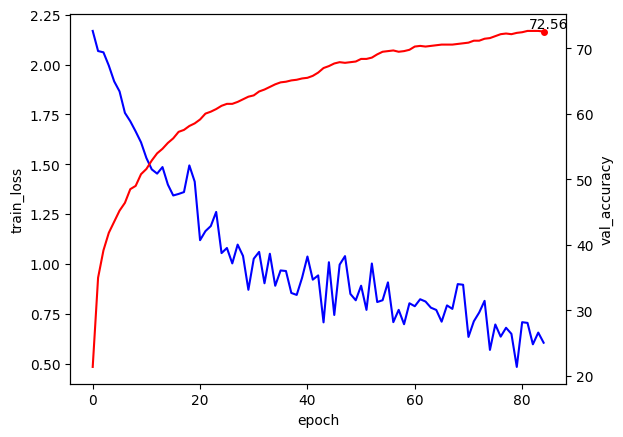

In [24]:
metrics = pd.read_csv('./checkpoints/lightning_logs/version_3/metrics.csv')

temp_df = pd.pivot_table(metrics, index='epoch', values=['train_loss', 'val_accuracy'])

sns.lineplot(temp_df['train_loss'], color='b') 
ax2 = plt.twinx()
sns.lineplot(temp_df['val_accuracy'], color='r', ax=ax2)
ax2.plot(len(temp_df) - 1, temp_df.iloc[-1, 1], marker='o', color='r', markersize=4)
ax2.annotate(temp_df.iloc[-1, 1].round(2), xy=(len(temp_df), temp_df.iloc[-1, 1]), horizontalalignment='center', verticalalignment='bottom')
plt.show()

Minimum training loss was around `0.5` and highest validation accuracy is `72.56%`.

### Testing

Test accuracy: 0.7196818590164185


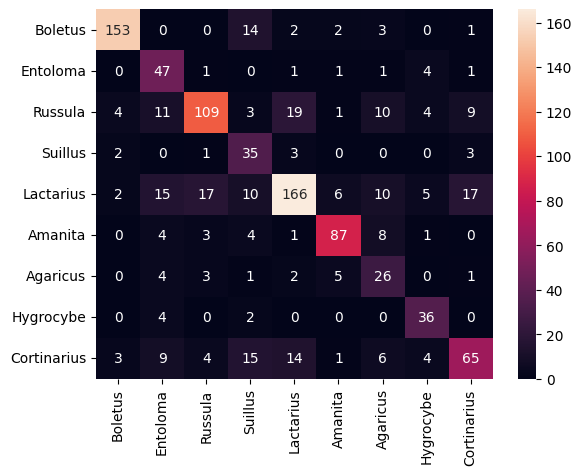

In [25]:
total_correct = 0

all_labels = []
all_predictions = []

for inputs, labels in test_dataloader:
    outputs = model.cuda()(inputs)
    _, predictions = torch.max(outputs, dim=1)
    total_correct += torch.sum(predictions == labels)

    for label, pred in zip(labels, predictions):
        label = int(label.data.cpu().numpy())
        pred = int(pred.data.cpu().numpy())
        
        all_labels.append(label)
        all_predictions.append(pred)

accuracy = total_correct / dataset_sizes['test']

print(f'Test accuracy: {accuracy}')

conf = confusion_matrix(all_labels, all_predictions)
sns.heatmap(conf, xticklabels=classes, yticklabels=classes, annot=True, fmt='g')
plt.show()

Final testing accuracy of second model is 71.96%.

### Saving the Model

In [26]:
torch.save(model, './models/model_1.pt')

***

# Summary

We have created a model that achieves an accuracy of ~72%.

It took 35 minutes to train with more than 4000 instances and 9 classes.